In [24]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torchbnn as bnn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats
import seaborn as sns

### Variational Inference

In [25]:
df = pd.read_csv("GlobalWeatherRepository.csv")

features = ["humidity", "wind_kph", "pressure_mb", "precip_mm", "cloud", "visibility_km", "uv_index"]
target = "temperature_celsius"

df = df.dropna(subset=features + [target])

X = df[features].values
y = df[target].values.reshape(-1, 1)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24520800)
torch.manual_seed(24520800)
np.random.seed(24520800)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [26]:
model_vi = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=len(features), out_features=128),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=128, out_features=64),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=1),
)

kl_loss = bnn.BKLLoss(reduction="mean")
optimizer = torch.optim.Adam(model_vi.parameters(), lr=0.01)

kl_weight = 0.01

In [27]:
def gaussian_nll(y, y_hat, sigma=1.0):
    return 0.5 * torch.mean((y - y_hat)**2 / sigma**2)

In [28]:
def gaussian_nll_forward_backward(y, y_hat, sigma=1.0):
    N = y.shape[0]

    # forward
    residual = y_hat - y  # (N,1)
    loss = 0.5 * torch.mean(residual**2) / sigma**2

    # backward (dL/dy_hat)
    grad_y_hat = residual / (N * sigma**2)  # (N,1)

    return loss, grad_y_hat

In [29]:
epochs = 1000
history_loss = []

for epoch in range(epochs):
    pred = model_vi(X_train)
    nll, grad_pred = gaussian_nll_forward_backward(y_train, pred)
    kl = kl_loss(model_vi)
    loss = nll + kl_weight * kl

    optimizer.zero_grad()
    (kl * kl_weight).backward(retain_graph=True)
    pred.backward(grad_pred)
    optimizer.step()

    history_loss.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total Loss: {loss.item():.4f} | NLL: {nll.item():.4f}")

Epoch 0 | Total Loss: 0.5943 | NLL: 0.5907
Epoch 100 | Total Loss: 0.2755 | NLL: 0.2701
Epoch 200 | Total Loss: 0.2893 | NLL: 0.2834
Epoch 300 | Total Loss: 0.2435 | NLL: 0.2374
Epoch 400 | Total Loss: 0.2378 | NLL: 0.2317
Epoch 500 | Total Loss: 0.2226 | NLL: 0.2161
Epoch 600 | Total Loss: 0.2309 | NLL: 0.2239
Epoch 700 | Total Loss: 0.2194 | NLL: 0.2126
Epoch 800 | Total Loss: 0.2132 | NLL: 0.2064
Epoch 900 | Total Loss: 0.2177 | NLL: 0.2109


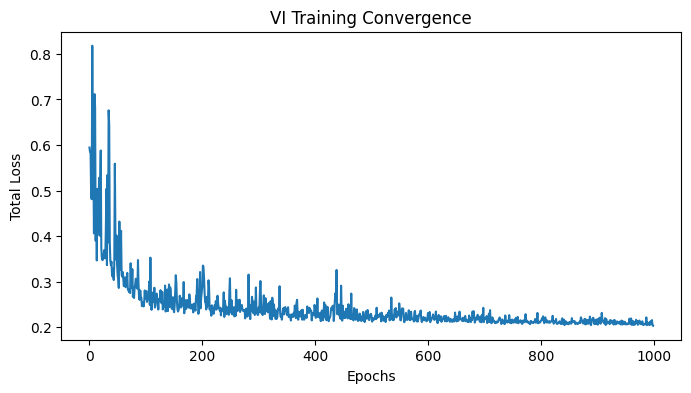

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(history_loss)
plt.title("VI Training Convergence")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.show()

In [31]:
# Predictive Inference
model_vi.eval()
samples = 100
preds = []

with torch.no_grad():
    for i in range(samples):
        # Each pass samples different weights from the learned distribution
        preds.append(model_vi(X_test).numpy().flatten())

# Calculate Mean and Std Dev
preds = np.array(preds)
mean_vi = preds.mean(axis=0)
std_vi  = preds.std(axis=0)

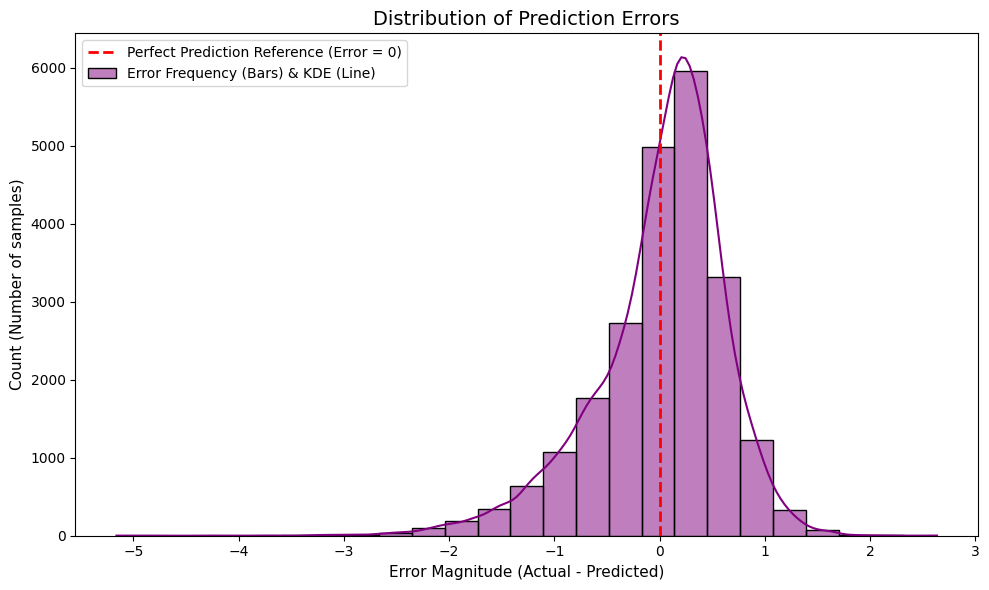

In [32]:
y_actual = y_test.numpy().flatten()
y_predicted = mean_vi
residuals = y_actual - y_predicted

plt.figure(figsize=(10, 6))

sns.histplot(residuals, kde=True, color='purple', bins=25,
             label='Error Frequency (Bars) & KDE (Line)')

plt.axvline(0, color='red', linestyle='--', linewidth=2,
            label='Perfect Prediction Reference (Error = 0)')

plt.title('Distribution of Prediction Errors', fontsize=14)
plt.xlabel('Error Magnitude (Actual - Predicted)', fontsize=11)
plt.ylabel('Count (Number of samples)', fontsize=11)

plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

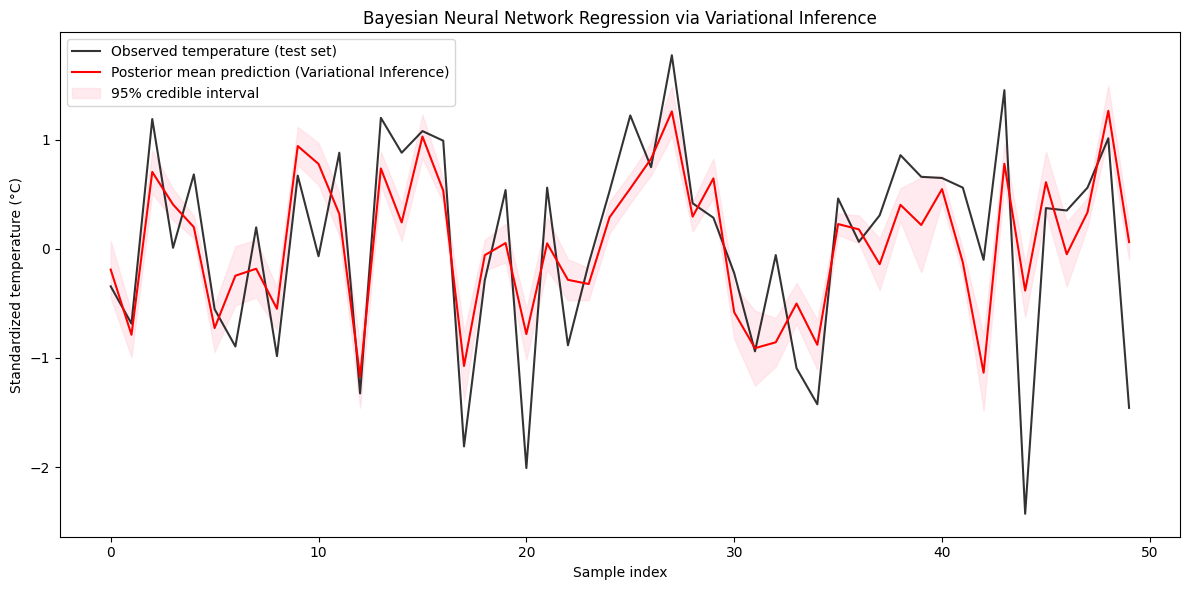

In [33]:
plt.figure(figsize=(12, 6))

plt.plot(
    y_test[:50].numpy(),
    color="black",
    label="Observed temperature (test set)",
    alpha=0.8
)

plt.plot(
    mean_vi[:50],
    color="red",
    label="Posterior mean prediction (Variational Inference)"
)

plt.fill_between(
    range(50),
    mean_vi[:50] - 2 * std_vi[:50],
    mean_vi[:50] + 2 * std_vi[:50],
    color="pink",
    alpha=0.3,
    label="95% credible interval"
)

plt.xlabel("Sample index")
plt.ylabel("Standardized temperature (°C)")
plt.title("Bayesian Neural Network Regression via Variational Inference")

plt.legend()
plt.tight_layout()
plt.show()

### MCMC

In [34]:
# Define Bayesian (Stochastic Function)
class SimpleBNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x).squeeze()

In [35]:
def gaussian_loglikelihood_grad(y, preds, noise_std=1.0):
    return (y - preds) / (noise_std**2)

In [36]:
def log_prior(model, prior_std=1.0):
    log_p = 0.0
    for p in model.parameters():
        log_p += -0.5 * torch.sum(p**2) / prior_std**2
    return log_p

In [37]:
def log_posterior(model, X, y, noise_std=1.0, prior_std=1.0):
    preds = model(X)

    log_likelihood = -0.5 * torch.sum((y - preds) ** 2) / noise_std**2

    log_prior = 0.0
    for p in model.parameters():
        log_prior += -0.5 * torch.sum(p ** 2) / prior_std**2

    return log_likelihood + log_prior

In [38]:
def langevin_sampler(
    model, X, y,
    step_size = 5e-5,
    n_steps=3000,
    burn_in=1000
):
    samples = []
    param_samples = []

    for step in range(n_steps):
        model.zero_grad()

        log_post = log_posterior(model, X, y)

        if torch.isnan(log_post) or torch.isinf(log_post):
            print(f"NaN detected at step {step}")
            break

        preds = model(X)

        # manual grad w.r.t output
        grad_preds = gaussian_loglikelihood_grad(y, preds)

        model.zero_grad()
        preds.backward(grad_preds, retain_graph=True)

        # Autograd gradient for log-prior
        lp = log_prior(model)
        lp.backward()

        with torch.no_grad():
            for p in model.parameters():
                noise_scale = np.sqrt(step_size)
                noise = torch.randn_like(p) * noise_scale
                p += 0.5 * step_size * p.grad + noise
                p.grad.zero_()

        param_samples.append(
            torch.cat([p.detach().flatten() for p in model.parameters()]).cpu().numpy()
            )

        if step >= burn_in:
            samples.append([
                p.detach().clone() for p in model.parameters()
            ])

        if step % 500 == 0:
            print(f"[MCMC] Step {step} | LogPosterior = {log_post.item():.2f}")

    return samples, param_samples

In [39]:
def predict_from_samples(model, samples, X):
    preds = []

    for s in samples:
        with torch.no_grad():
            for p, sp in zip(model.parameters(), s):
                p.copy_(sp)
            preds.append(model(X).numpy())

    return np.array(preds)

In [40]:
X_mcmc = X_train[:200]
y_mcmc = y_train[:200].squeeze()

model_mcmc = SimpleBNN(X_mcmc.shape[1])
samples, param_samples = langevin_sampler(model_mcmc, X_mcmc, y_mcmc)

param_samples = np.array(param_samples)

[MCMC] Step 0 | LogPosterior = -126.29
[MCMC] Step 500 | LogPosterior = -69.30
[MCMC] Step 1000 | LogPosterior = -65.55
[MCMC] Step 1500 | LogPosterior = -65.21
[MCMC] Step 2000 | LogPosterior = -63.13
[MCMC] Step 2500 | LogPosterior = -66.82


In [41]:
preds_mcmc = predict_from_samples(model_mcmc, samples, X_mcmc)

mean_mcmc = preds_mcmc.mean(axis=0)
std_mcmc  = preds_mcmc.std(axis=0)

In [42]:
burn_in = int(0.3 * len(param_samples))

param_index = min(120, param_samples.shape[1] - 1)

trace = param_samples[:, param_index]
burn_in_trace = trace[:burn_in]
posterior_trace = trace[burn_in:]

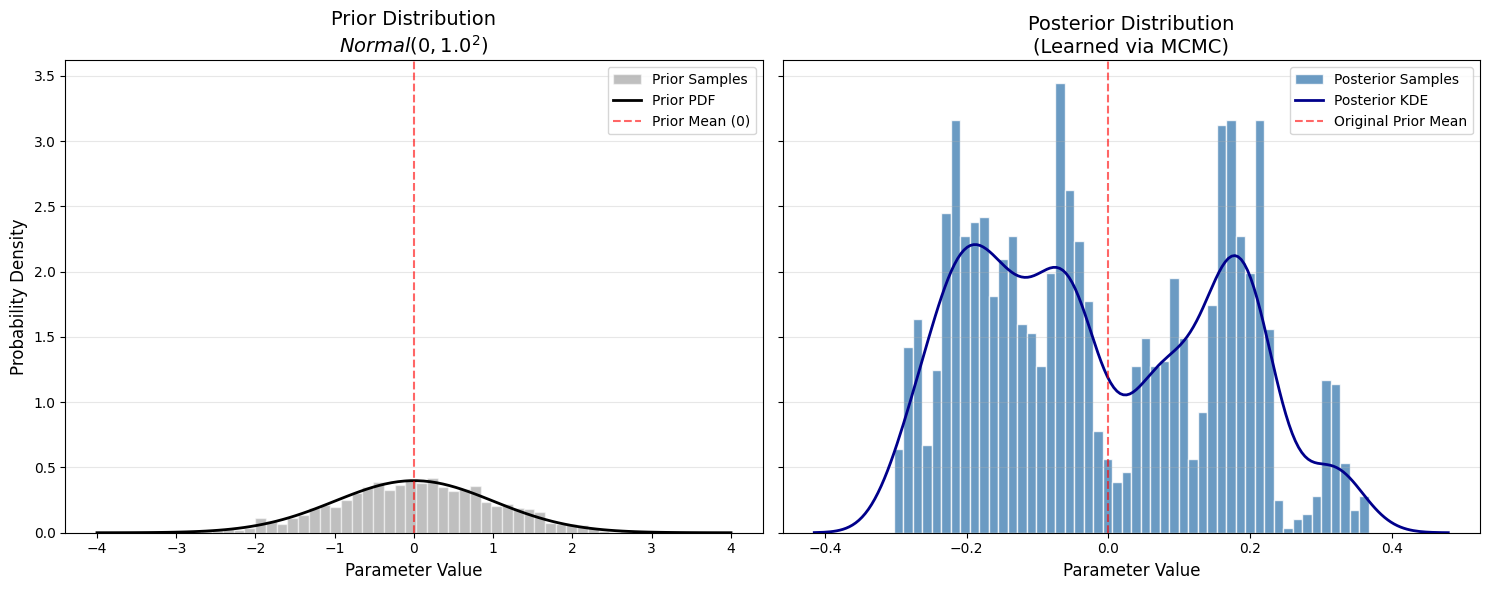

In [43]:
prior_std = 1.0

posterior_samples = param_samples[burn_in:, param_index]

prior_samples = np.random.normal(0, prior_std, size=len(posterior_samples))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# prior
ax1.hist(prior_samples, bins=50, density=True, color='gray', alpha=0.5, edgecolor='white', label='Prior Samples')

x_prior = np.linspace(-4, 4, 100)
ax1.plot(x_prior, stats.norm.pdf(x_prior, 0, prior_std), color='black', lw=2, label='Prior PDF')
ax1.axvline(0, color='red', linestyle='--', alpha=0.6, label='Prior Mean (0)')

ax1.set_title(f'Prior Distribution\n$Normal(0, {prior_std}^2)$', fontsize=14)
ax1.set_xlabel('Parameter Value', fontsize=12)
ax1.set_ylabel('Probability Density', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# posterior
ax2.hist(posterior_samples, bins=50, density=True, color='steelblue', alpha=0.8, edgecolor='white', label='Posterior Samples')

sns.kdeplot(posterior_samples, ax=ax2, color='darkblue', linewidth=2, label='Posterior KDE')

ax2.axvline(0, color='red', linestyle='--', alpha=0.6, label='Original Prior Mean')

ax2.set_title(f'Posterior Distribution\n(Learned via MCMC)', fontsize=14)
ax2.set_xlabel('Parameter Value', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

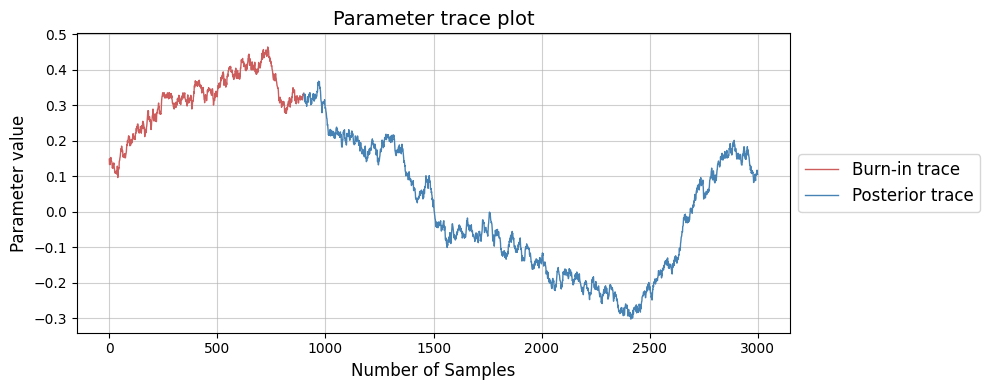

In [44]:
plt.figure(figsize=(10, 4))

plt.plot(np.arange(0, burn_in), trace[:burn_in],
         color='indianred', label='Burn-in trace', linewidth=1)

plt.plot(np.arange(burn_in, len(trace)), trace[burn_in:],
         color='steelblue', label='Posterior trace', linewidth=1)

plt.title('Parameter trace plot', fontsize=14)
plt.xlabel('Number of Samples', fontsize=12)
plt.ylabel('Parameter value', fontsize=12)

plt.grid(True, linestyle='-', alpha=0.6)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

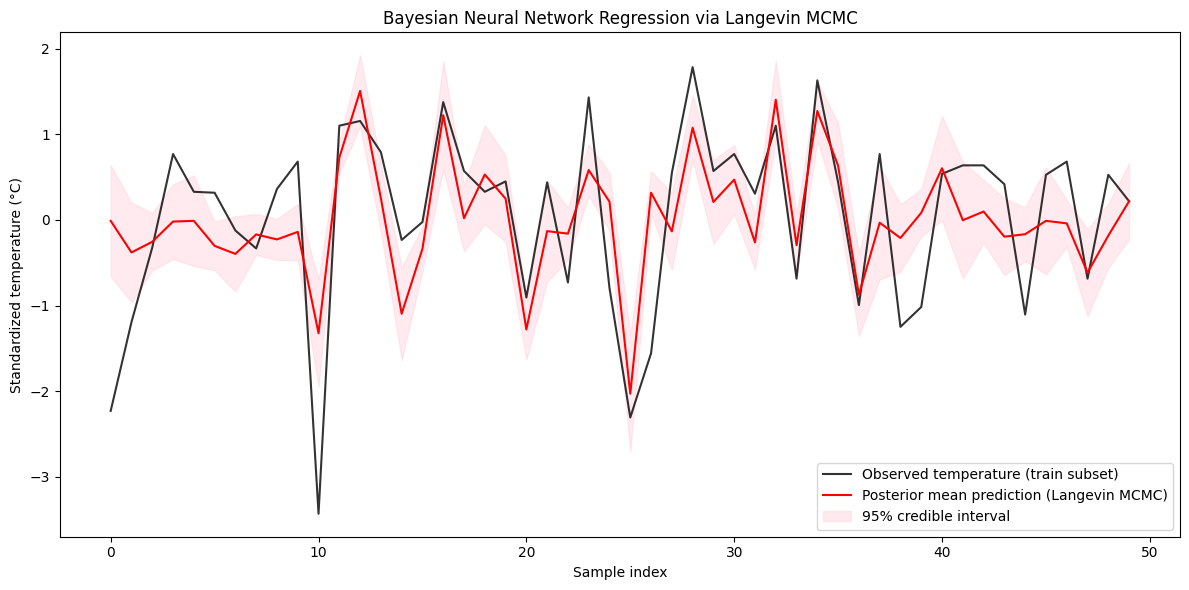

In [45]:
plt.figure(figsize=(12, 6))

plt.plot(
    y_mcmc[:50].numpy(),
    color="black",
    label="Observed temperature (train subset)",
    alpha=0.8
)

plt.plot(
    mean_mcmc[:50],
    color="red",
    label="Posterior mean prediction (Langevin MCMC)"
)

plt.fill_between(
    range(50),
    mean_mcmc[:50] - 2 * std_mcmc[:50],
    mean_mcmc[:50] + 2 * std_mcmc[:50],
    color="pink",
    alpha=0.3,
    label="95% credible interval"
)

plt.xlabel("Sample index")
plt.ylabel("Standardized temperature (°C)")
plt.title("Bayesian Neural Network Regression via Langevin MCMC")

plt.legend()
plt.tight_layout()
plt.show()

### Performance Comparison

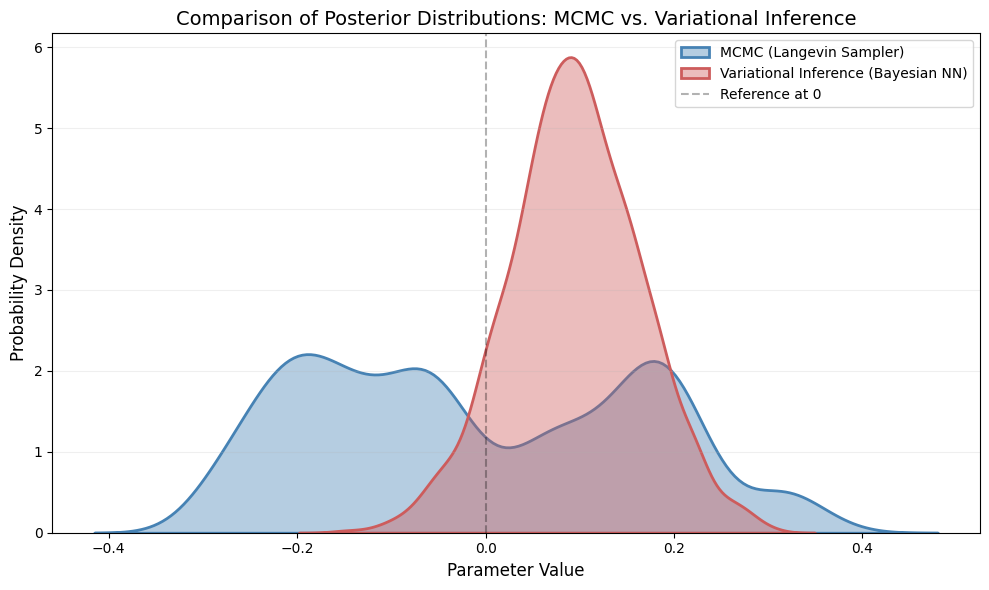

In [46]:
vi_samples = []
with torch.no_grad():
    for _ in range(2000):
        weight_sample = model_vi[0].weight_mu[0,0] + \
                        torch.randn(1) * torch.exp(model_vi[0].weight_log_sigma[0,0])
        vi_samples.append(weight_sample.item())

mcmc_samples = param_samples[burn_in:, param_index]

plt.figure(figsize=(10, 6))

sns.kdeplot(mcmc_samples, color='steelblue', fill=True, label='MCMC (Langevin Sampler)', linewidth=2, alpha=0.4)

sns.kdeplot(vi_samples, color='indianred', fill=True, label='Variational Inference (Bayesian NN)', linewidth=2, alpha=0.4)

plt.title('Comparison of Posterior Distributions: MCMC vs. Variational Inference', fontsize=14)
plt.xlabel('Parameter Value', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.axvline(0, color='black', linestyle='--', alpha=0.3, label='Reference at 0')

plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()